## Load Data

* Statistics
* Exploration
* Organize in CSV

In [1]:
import glob
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random
from PIL import ImageFile
import os.path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import tensorflow as tf
import random
import pickle
from sklearn.preprocessing import StandardScaler
ImageFile.LOAD_TRUNCATED_IMAGES = True


%matplotlib inline


def encode_labels(data, label, target):
    le = preprocessing.LabelEncoder()
    le.fit(data[label])
    data[target] = le.transform(data[label]) 
    return data

def create_data(images_path, rebuild=False, path="../train/original.csv"):
    
    if os.path.isfile(path) and (not rebuild):
        print("Returning data from file")
        return encode_labels(pd.read_csv(path), 'label', 'target')

    print("Generating Data")
    data = []
    for impath in images_path:
        line = path.split("/") #['..', 'train', 'Type_1', '0.jpg']
        img  = mpimg.imread(impath, "JPG")
        item = {
                "image": impath,
                "label": line[2],
                "desc": "raw",
                "height": img.shape[0],
                "width": img.shape[1]
               }
        data.append(item)
    random.shuffle(data)
   
    data = pd.DataFrame(data)
    data.to_csv(path, index=False, columns=["image", "label", "desc", "height", "width"])
    
    return encode_labels(data, 'label', 'target')

In [2]:
images = glob.glob("../original/**/*.jpg")
data = create_data(images, rebuild=False)

Returning data from file


In [3]:
data.shape

(8210, 6)

In [4]:
data.head()

,image,label,desc,height,width,target
0,../original/Type_2/5104.jpg,Type_2,raw,3264,2448,1
1,../original/Type_3/3397.jpg,Type_3,raw,4128,3096,2
2,../original/Type_1/523.jpg,Type_1,raw,4160,3120,0
3,../original/Type_2/750.jpg,Type_2,raw,4128,3096,1
4,../original/Type_3/3356.jpg,Type_3,raw,4128,3096,2


### DataExploration

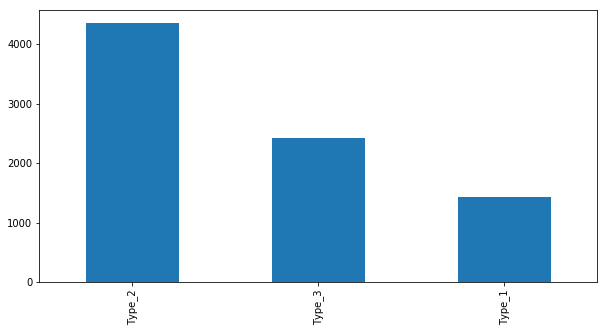

In [5]:
data["label"].value_counts().plot(kind='bar',figsize=(10,5))

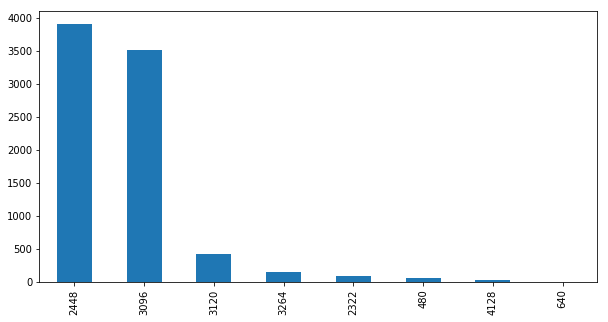

In [6]:
data["width"].value_counts().plot(kind='bar',figsize=(10,5))

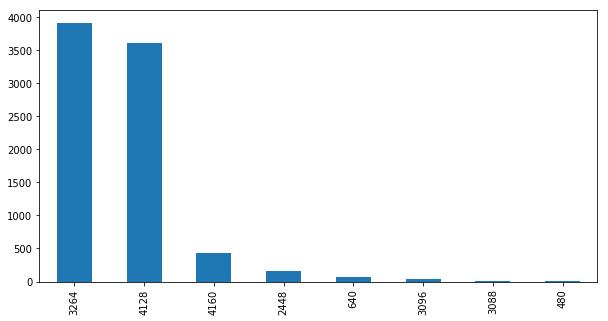

In [7]:
data["height"].value_counts().plot(kind='bar',figsize=(10,5))

In [8]:
label1 = data[data["label"]=="Type_1"]
label2 = data[data["label"]=="Type_2"]
label3 = data[data["label"]=="Type_3"]
print("type1 {}, type2 {}, type3 {}, Total({}).".format(label1.shape[0], label2.shape[0], label3.shape[0], (label1.shape[0]+label2.shape[0]+label3.shape[0])))

type1 1438, type2 4346, type3 2426, Total(8210).


In [9]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(4, 4))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=7, pad=4)
    ax.set_xlabel(axis_labels[0], fontsize=8, labelpad=8)
    ax.set_ylabel(axis_labels[1], fontsize=8, labelpad=8)
    ax.set_zlabel(axis_labels[2], fontsize=8, labelpad=8)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def get_image(path):
    return cv2.imread(path)

def plot_3d_channels(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    rgb_scaled = rgb /255.0

    plot3d(rgb, rgb_scaled)
    plt.show()

    plot3d(hls, rgb_scaled, axis_labels=list("HLS"))
    plt.show()

def get_space(image, space="RGB"):
    image_ = np.copy(image)
    if space == "HSV":
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2HSV)
    elif space == "HLS":
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2HLS)
    elif space == "YUV":
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2YUV)
    elif space == "YCrCb":
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2YCrCb)
    elif space == "GRAY":
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2GRAY)
    else:
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        
    return image_

def plotspasce(image, space="RGB"):
    image_ = get_space(image)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))
    f.tight_layout()

    ax1.imshow(image_[:,:,0])
    ax2.imshow(image_[:,:,1])
    ax3.imshow(image_[:,:,2])    

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return image_

def get_hog_features(img, orient=6, pix_per_cell=12, cell_per_block=2, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def plot_hog(image, space="RGB"):
    image_ = get_space(image, space=space)
    hog_fet1, hogim_1 = get_hog_features(image_[:,:,0], feature_vec=False, vis=True)
    hog_fet2, hogim_2 = get_hog_features(image_[:,:,1], feature_vec=False, vis=True)
    hog_fet3, hogim_3 = get_hog_features(image_[:,:,2], feature_vec=False, vis=True)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))
    f.tight_layout()

    ax1.imshow(hogim_1)
    ax2.imshow(hogim_2)
    ax3.imshow(hogim_3)    

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return (image_, hog_fet1, hogim_1)

def get_hist_features(image, space="RGB", nbins=32, bins_range=(0, 256), debug=False):
    image_ = get_space(image, space=space)

    if space == "GRAY":
        return np.histogram(image_[:,:,0], bins=nbins, range=bins_range)
        
    channel1_hist = np.histogram(image_[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image_[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image_[:,:,2], bins=nbins, range=bins_range)

    ch1 = channel1_hist[0]
    ch2 = channel2_hist[0]
    ch3 =  channel3_hist[0]
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    features = np.concatenate((ch1, ch2, ch3)) 

    return (ch1, ch2, ch3, bin_centers, features)

def plot_hist_features(image, space="RGB", name="no-set"):
    (a, b, c, bincen, _) = get_hist_features(image, space=space, debug=True)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, a)
    plt.xlim(0, 256)
    plt.title('CH1 Histogram'+':'+space+':'+name)
    plt.subplot(132)
    plt.bar(bincen, b)
    plt.xlim(0, 256)
    plt.title('CH2 Histogram'+':'+space+':'+name)
    plt.subplot(133)
    plt.bar(bincen, c)
    plt.xlim(0, 256)
    plt.title('CH3 Histogram'+':'+space+':'+name)
    fig.tight_layout()
    

In [10]:
sample_type_1 = get_image(label1["image"][random.choice(label1.index)])
sample_type_2 = get_image(label2["image"][random.choice(label2.index)])
sample_type_3 = get_image(label3["image"][random.choice(label3.index)])


In [11]:
def extract_feature(image):
    sample1hist = get_hist_features(image, space="HSL", nbins=32, bins_range=(0, 256), debug=False)[-1]
    image_ = get_space(image, space="HSL")
    hog_fet1= get_hog_features(image_[:,:,0], feature_vec=True)
    #hog_fet2= get_hog_features(image_[:,:,1], feature_vec=True)
    #hog_fet3= get_hog_features(image_[:,:,2], feature_vec=True)
    return np.concatenate((hog_fet1, sample1hist))

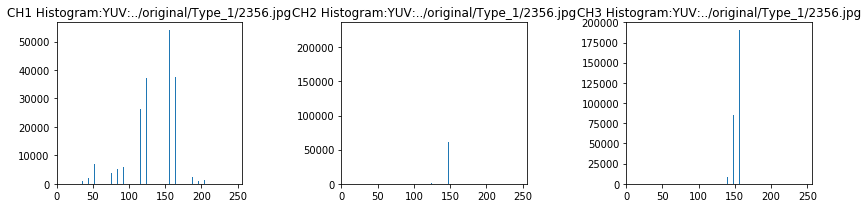

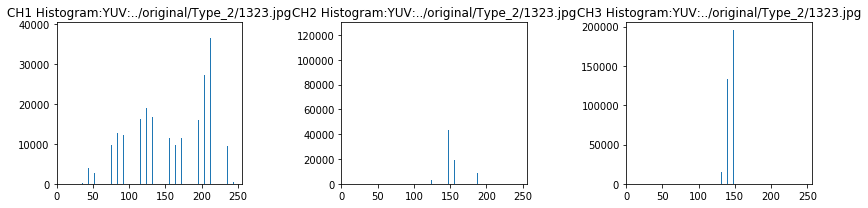

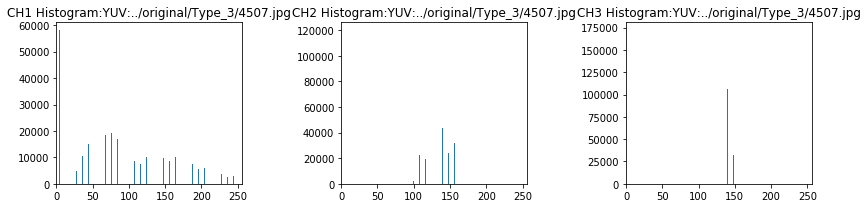

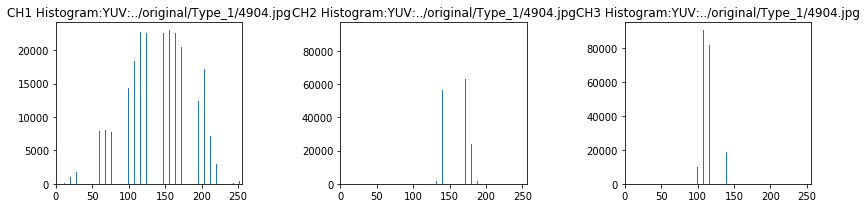

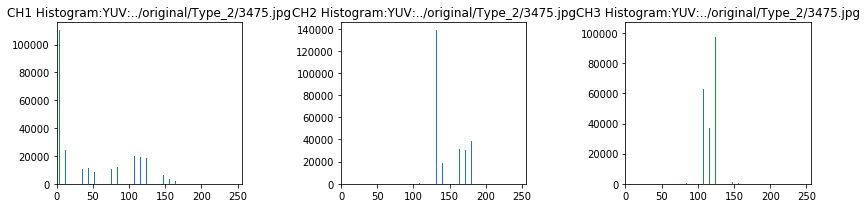

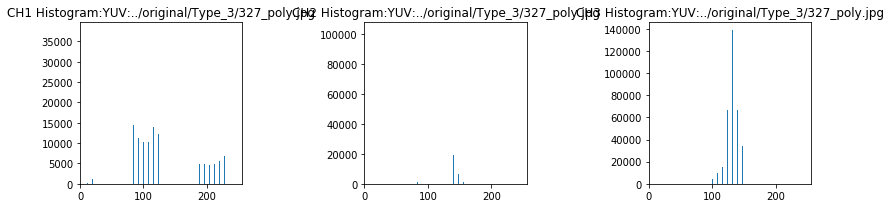

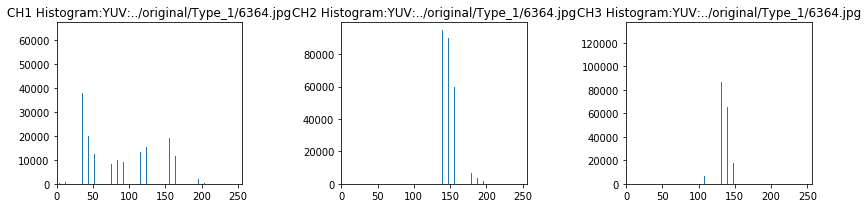

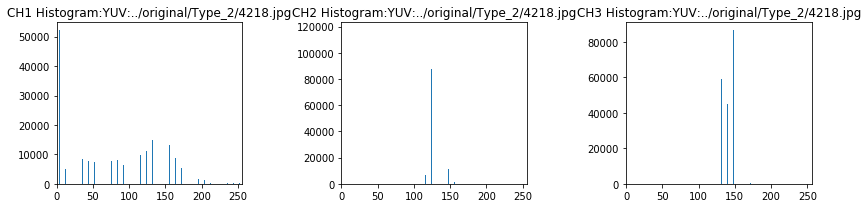

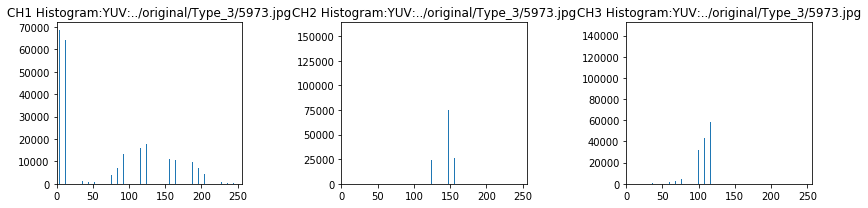

In [12]:
for i in range(3):
    rindx1 = random.choice(label1.index)
    rindx2 = random.choice(label2.index)
    rindx3 = random.choice(label3.index)
    sample_type_1 = get_image(label1["image"][rindx1])
    sample_type_2 = get_image(label2["image"][rindx2])
    sample_type_3 = get_image(label3["image"][rindx3]) 
#     plot_hist_features(sample_type_1, space="RGB", name=label1["image"][rindx1])
#     plot_hist_features(sample_type_1, space="HSV", name=label1["image"][rindx1])
#     plot_hist_features(sample_type_1, space="HLS", name=label1["image"][rindx1])
    plot_hist_features(sample_type_1, space="YUV", name=label1["image"][rindx1])
    
#     plot_hist_features(sample_type_2, space="RGB", name=label2["image"][rindx2])
#     plot_hist_features(sample_type_2, space="HSV", name=label2["image"][rindx2])
#     plot_hist_features(sample_type_2, space="HLS", name=label2["image"][rindx2])
    plot_hist_features(sample_type_2, space="YUV", name=label2["image"][rindx2])

#     plot_hist_features(sample_type_3, space="RGB", name=label3["image"][rindx3])
#     plot_hist_features(sample_type_3, space="HSV", name=label3["image"][rindx3])
#     plot_hist_features(sample_type_3, space="HLS", name=label3["image"][rindx3])
    plot_hist_features(sample_type_3, space="YUV", name=label3["image"][rindx3])

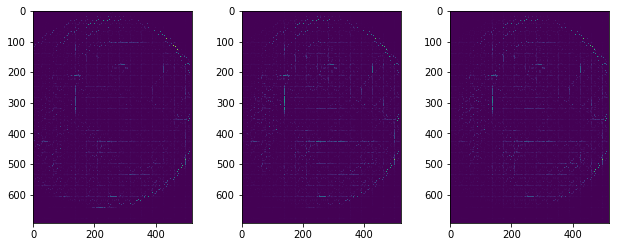

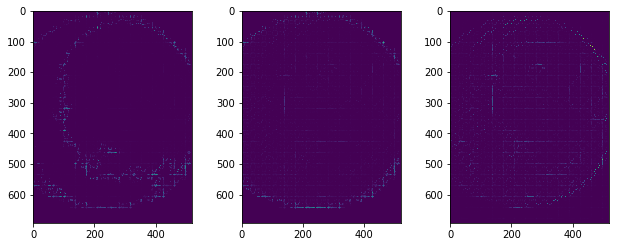

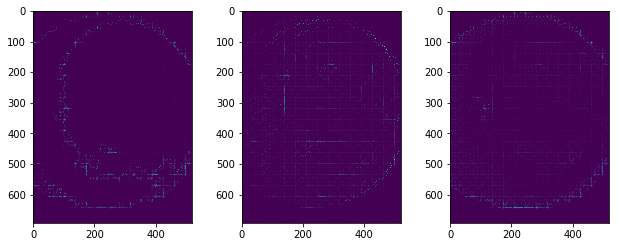

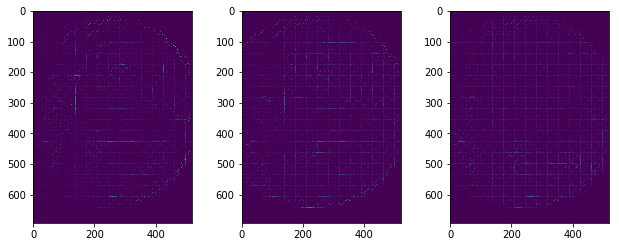

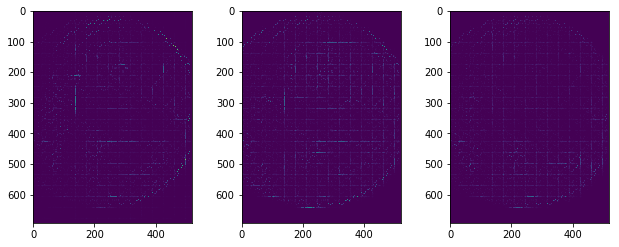

In [15]:
_ = plot_hog(sample_type_2, space="RGB")
_ = plot_hog(sample_type_2, space="HSV")
_ = plot_hog(sample_type_2, space="HLS")
_ = plot_hog(sample_type_2, space="YUV")
xx = plot_hog(sample_type_2, space="YCrCb")

In [12]:
def debug_images(img1, img2, title1, title2):
    """
    Debug image by showing a set the titles
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    f.tight_layout()

    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1, fontsize=11)

    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=11)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

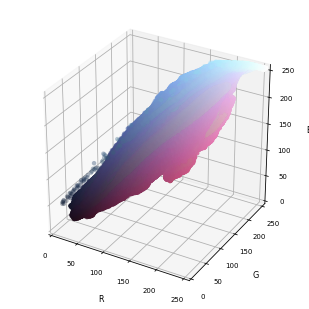

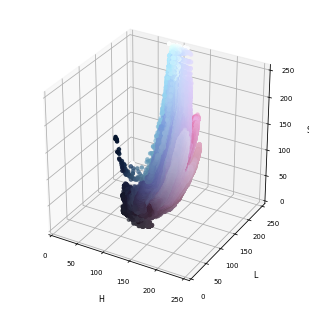

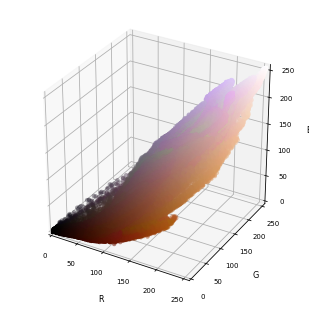

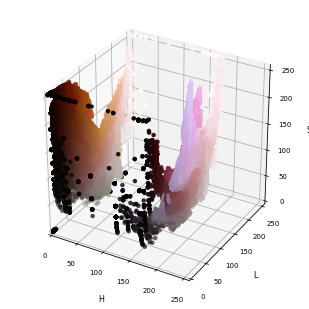

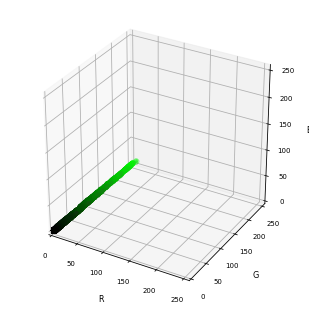

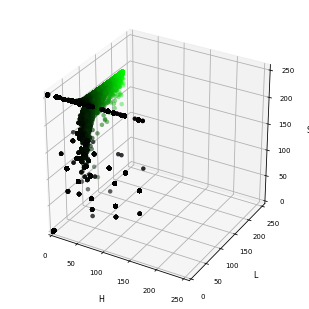

In [21]:
plot_3d_channels(sample_type_1)
plot_3d_channels(sample_type_2)
plot_3d_channels(sample_type_3)

In [13]:
max_num_examples = label2.shape[0]
num_to_label1 = max_num_examples - label1.shape[0]
num_to_label3 = max_num_examples - label3.shape[0]
print(max_num_examples, num_to_label1, num_to_label3)

label1.to_csv("../train/originalt1.csv", index=False, columns=["image", "label", "desc", "height", "width"])
label2.to_csv("../train/originalt2.csv", index=False, columns=["image", "label", "desc", "height", "width"])
label3.to_csv("../train/originalt3.csv", index=False, columns=["image", "label", "desc", "height", "width"])

4346 2908 1920


In [14]:
4346*3
data = create_data(images, rebuild=False, path="../train/data.csv")

Returning data from file


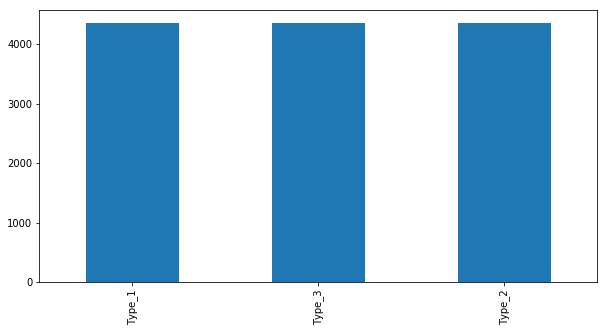

In [15]:
data["label"].value_counts().plot(kind='bar',figsize=(10,5))

#### Implementation 

In [16]:
def resize_image(img, size=(820, 620), debug=False):
    """
    resize image and return it
    """
    h = size[0]
    w = size[1]
    img_ = cv2.resize(img, (w, h))
    if debug:
        debug_images(img, img_, "old shape {}".format(img.shape), "new shape {}".format(img_.shape))
    return img_

In [17]:
ff=  extract_feature(image =resize_image(sample_type_1, (346, 260)))
ff.shape


(13056,)

In [18]:
ii = mpimg.imread(data["image"][0])
ii.shape

(693, 520, 3)

In [19]:
def scale_image(img):
    return img / 255.0 - 0.5

In [20]:
def lambda_layer(image):
    img_ = np.copy(image)
    img_ = resize_image(img_, (205, 155))
#     img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    img_ = scale_image(img_)
    return img_

In [21]:
from tensorflow.contrib.layers import flatten

def NN5(x):    
    mu = 0
    sigma = 0.1

    fc1_W = tf.Variable(tf.truncated_normal(shape=(13056, 600), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(600))
    fc1   = tf.matmul(x, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    fc1   = tf.nn.dropout(fc1, keep_prob1)
    

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(600, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    fc2    = tf.nn.relu(fc2)
    fc2   = tf.nn.dropout(fc2, keep_prob1)
    

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 3), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(3))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [22]:
EPOCHS = 3
BATCH_SIZE = 10
rate = 0.001

In [23]:
#prepare data
train_samples, validation_samples = train_test_split(data, test_size=0.4)
validation_samples, test_samples  = train_test_split(validation_samples, test_size=0.3)
train_samples = train_samples.reset_index(drop=True) 
validation_samples = validation_samples.reset_index(drop=True) 
test_samples = test_samples.reset_index(drop=True) 

In [24]:
pickle_path = "./extracted_features.p"



if (not os.path.exists(pickle_path) ):

#### Execute just once!!!!!!

    Xtrain = []
    ytrain = np.array(train_samples["target"], dtype=np.int)
    for idx in train_samples.index:
        path = train_samples["image"][idx]
        image = get_image(path)
#         if image.shape[0] != 693 or image.shape[1] != 520:
        image =resize_image(image, (346, 260))
        features = extract_feature(image)
        Xtrain.append(features.astype(np.float64))


    X_scaler = StandardScaler().fit(Xtrain)
   
    dist_pickle = {}
    dist_pickle["Xscaler"] = X_scaler
    pickle.dump( dist_pickle, open( pickle_path, "wb" ) )


dist_pickle = pickle.load( open( pickle_path, "rb" ) )

X_scaler = dist_pickle["Xscaler"]


In [25]:
def get_data_features(samples):
    X = []
    y = np.array(samples["target"], dtype=np.int)
    for idx in samples.index:
        path = samples["image"][idx]
        image = get_image(path)
#         if image.shape[0] != 693 or image.shape[1] != 520:
        image =resize_image(image, (346, 260))
        features = extract_feature(image)
        X.append(features.astype(np.float64))
    return (X_scaler.transform(X), y)


In [27]:
ss = get_data_features(train_samples[3:6])
set([x.shape[0] for x in ss[0]])

{13056}

In [28]:
type(ss[1])
ss[0].shape

(3, 13056)

In [29]:
np.array([])

array([], dtype=float64)

In [30]:
x = tf.placeholder(tf.float32, (None, 13056))
y = tf.placeholder(tf.int32, (None))
keep_prob1 = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 3)

In [31]:
logits = NN5(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [32]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_samples)
    num_examples_valid = len(validation_samples)
    print("Training...")
    print()
    for i in range(EPOCHS):
        train_samples_ = train_samples.sample(frac=1).reset_index(drop=True) 
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_data_features(train_samples_[offset:end])
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob1: 0.5})
        try:
            total_accuracy = 0
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x, batch_y = get_data_features(train_samples_[offset:offset+BATCH_SIZE])
                accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob1: 1.0})
                total_accuracy += (accuracy * len(batch_x))
            train_accuracy = total_accuracy / num_examples
        except Exception as e :
            print(batch_x.shape)
            print(batch_y.shape)
            raise e
        total_accuracy = 0
        for offset in range(0, num_examples_valid, BATCH_SIZE):
            batch_x, batch_y = get_data_features(validation_samples[offset:offset+BATCH_SIZE])
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob1: 1.0})
            total_accuracy += (accuracy * len(batch_x))
        validation_accuracy = total_accuracy / num_examples
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.474
Validation Accuracy = 0.203

EPOCH 2 ...
Train Accuracy = 0.455
Validation Accuracy = 0.200



## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_generator, test_steps)
    print("Test Accuracy = {:.3f}".format(test_accuracy))